In [2]:
%pip install gdown
!pip install git+https://github.com/yidinghao/interpreting-nlp

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/yidinghao/interpreting-nlp to /tmp/pip-req-build-9h077v4y
  Running command git clone --filter=blob:none --quiet https://github.com/yidinghao/interpreting-nlp /tmp/pip-req-build-9h077v4y
  Resolved https://github.com/yidinghao/interpreting-nlp to commit b6bf81e2e52970ffe4db32cade8c9c3d48d1cd3b
  Preparing metadata (setup.py) ... done
  Created wheel for interpret-nlp: filename=interpret_nlp-0.1-py3-none-any.whl size=14714 sha256=2d091bae9460de4be04d2dbc201b0e5d9367f0fa387ec4bcc21de78bde34f0ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-cs_1khpi/wheels/c0/d4/0f/9d21571e687d4e3dcf61b6538dedff103fdc48bad18ca6c357
Successfully built interpret-nlp


In [3]:
train = '1HqceFWkRXwEqgPcuAtACFVvHhKO_TGG6'
val = '1XEsLOUFJTnCGcitk4IUS23H6IlzCzwqZ'
test = '1Lu5ItQvj2iGRqMXJ-bovQkys0eilR9HZ'

train_embeddings_per_word = '1-0Bb3pLy_EhEggA-VsOh8TIS92VbmmxV'
val_embeddings_per_word = '1-0WpebJIz9q2PZ_Baf51ZUsiBx9pWVJP'
test_embeddings_per_word = '1pi6DGhZ7AoGzC3cqP-ET5Qvkc3HD33bo'

train_embeddings_per_sentence = '1-260zeDhoDdxQ3McfR7Hr4c6mfaLFBpa'
val_embeddings_per_sentence = '1-2EN_l5NcdgJZ740Szt4g6RcIZ9GX_D2'
test_embeddings_per_sentence = '1gNKahNHussBAV-6mFyC66AxPTA0YhQAG'

In [4]:
!gdown {train}
!gdown {val}
!gdown {test}

!gdown {train_embeddings_per_word}
!gdown {val_embeddings_per_word}
!gdown {test_embeddings_per_word}

Downloading...
From: https://drive.google.com/uc?id=1HqceFWkRXwEqgPcuAtACFVvHhKO_TGG6
To: /kaggle/working/train_final.pkl
100%|███████████████████████████████████████| 3.47M/3.47M [00:00<00:00, 119MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XEsLOUFJTnCGcitk4IUS23H6IlzCzwqZ
To: /kaggle/working/val_final.pkl
100%|████████████████████████████████████████| 743k/743k [00:00<00:00, 90.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Lu5ItQvj2iGRqMXJ-bovQkys0eilR9HZ
To: /kaggle/working/test_final.pkl
100%|████████████████████████████████████████| 737k/737k [00:00<00:00, 86.0MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1-0Bb3pLy_EhEggA-VsOh8TIS92VbmmxV
From (redirected): https://drive.google.com/uc?id=1-0Bb3pLy_EhEggA-VsOh8TIS92VbmmxV&confirm=t&uuid=bae17830-758a-426f-9be6-46ad0351c532
To: /kaggle/working/train_embeddings_per_word.pkl
100%|██████████████████████████████████████| 1.08G/1.08G [00:18<00:00, 57.7MB/s]
Downloading...
From (uriginal)

In [5]:
import pandas as pd
import string
import re
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.isri import ISRIStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.svm import SVC
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from interpret_nlp.modules.lrp_modules import LRPLinear, LRPGRU
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from collections import OrderedDict
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.preprocessing import OneHotEncoder
import keras_tuner

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
label_to_class = {
    0: 'none',
    1: 'anger',
    2: 'joy',
    3: 'sadness',
    4: 'love',
    5: 'sympathy',
    6: 'surprise',
    7: 'fear'
}
classes = ['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear']

In [8]:
with open('/kaggle/working/train_final.pkl', 'rb') as f:
    train = pickle.load(f)
    
with open('/kaggle/working/val_final.pkl', 'rb') as f:
    val = pickle.load(f)

with open('/kaggle/working/test_final.pkl', 'rb') as f:
    test = pickle.load(f)

with open('/kaggle/working/train_embeddings_per_word.pkl', 'rb') as f:
    train_embeddings = pickle.load(f)
    
with open('/kaggle/working/val_embeddings_per_word.pkl', 'rb') as f:
    val_embeddings = pickle.load(f)
    
with open('/kaggle/working/test_embeddings_per_word.pkl', 'rb') as f:
    test_embeddings = pickle.load(f)

In [9]:
train.head()

,tweet,label,tweet_with_out_emojis,cleaned_data,Root Stemming,Light Stemming
5081,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,1,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,مهند ياحبيبي تدور لبش متاكد ابو جاسم مايدري,هند حبب تدر لبش تكد ابو جسم ايدر,مهند ياحبيبي تدور لبش متاكد ابو جاسم مايدري
8264,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,3,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,حلب عفرين اعتقال عشرات الشباب قريه باسوطه ريف ...,حلب عفر عقل عشر شبب قره بسط ريف عفر قوت هرب عش...,حلب عفر اعتقال عشر الشباب قريه باسوطه ريف عفر ...
9777,انا نفسي مره اجرب اكون ليك حد اقرب : ),3,انا نفسي مره اجرب اكون ليك حد اقرب : ),مره اجرب اكون ليك اقرب,مره جرب اكن ليك قرب,مره اجرب اكون ليك اقرب
740,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,3,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,الصراحه احساس مخزي نكتفي بالتمثيل المشرف الاول...,صرح حسس خزي كتف شرف اوليمبياد عوز صحه ريض,الصراحه احساس مخزي نكتفي بالتمثيل المشرف الاول...
6537,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,0,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,عاجل الايطالي فابيو باسل يفوز بدهب الاوليمبياد...,عجل يطل ابو بسل يفز دهب اوليمبياد جودو بطل علم...,عاجل الايطالي فابيو باسل يفوز بدهب الاوليمبياد...


In [10]:
X_train = train['Root Stemming']
y_train = train['label']
X_val = val['Root Stemming']
y_val = val['label']
X_test = test['Root Stemming']
y_test = test['label']

In [11]:
encoder = OneHotEncoder()

y_train = encoder.fit_transform(train['label'].values.reshape(-1,1)).toarray()
y_val = encoder.fit_transform(val['label'].values.reshape(-1,1)).toarray()
y_test = encoder.transform(test['label'].values.reshape(-1,1)).toarray()

In [12]:
def prepare_tokenization(train, val, test=None, pad=500):
  tokenizer = Tokenizer(oov_token='<UNK>')
  tokenizer.fit_on_texts(train)
  tokenizer.word_index['<PAD>'] = 0
  train = tokenizer.texts_to_sequences(train)
  val = tokenizer.texts_to_sequences(val)
  if not pad==False:
    train = sequence.pad_sequences(train, maxlen=pad)
    val = sequence.pad_sequences(val, maxlen=pad)
  if not type(test)==type(None):
    test = tokenizer.texts_to_sequences(test)
    if not pad==False:
      test = sequence.pad_sequences(test, maxlen=pad)
  v_size = len(tokenizer.word_index)
  print("Vocabulary size={}".format(v_size))
  print("Number of Documents={}".format(tokenizer.document_count))
  if not type(test)==type(None):
    return v_size, train, val, test
  else:
    return v_size, train, val

In [13]:
VOCAB_SIZE, train_sequences, val_sequences, test_sequences = prepare_tokenization(X_train, X_val, X_test, pad=False)

Vocabulary size=8030
Number of Documents=7045


(array([6.830e+02, 1.919e+03, 1.858e+03, 1.304e+03, 1.098e+03, 1.730e+02,
        8.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([ 0. ,  3.7,  7.4, 11.1, 14.8, 18.5, 22.2, 25.9, 29.6, 33.3, 37. ]),
 <BarContainer object of 10 artists>)

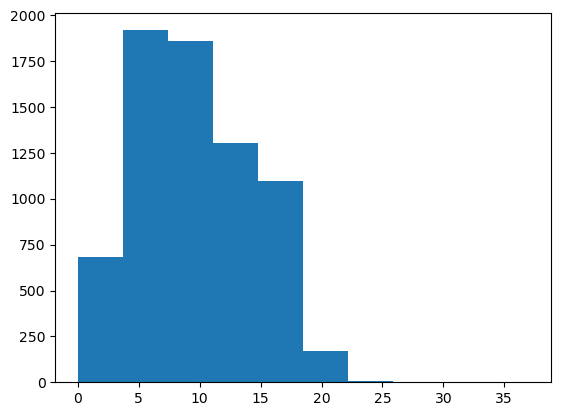

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
plt.hist(train_lens)

In [15]:
max_length = 50

In [16]:
max_length

50

In [17]:
X_train = sequence.pad_sequences(train_sequences, maxlen=max_length)
X_val = sequence.pad_sequences(val_sequences, maxlen=max_length)
X_test = sequence.pad_sequences(test_sequences, maxlen=max_length)
X_train.shape, X_val.shape, X_test.shape

((7045, 50), (1510, 50), (1510, 50))

In [18]:
BATCH_SIZE = 32
EPOCHS = 50
EMBED_SIZE = 768#86
LEARNING_RATE =  0.0053516485623658835

early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True)

In [19]:
class myDataset(Dataset):
  def __init__(self, train_sequences, labels):
      # save data
      self.train_sequences = train_sequences
      self.labels = labels

  def __getitem__(self, index):
      # retrieve data
      train_sequence = self.train_sequences[index]
      label = self.labels[index]

      return (torch.tensor(train_sequence).to(device), torch.tensor(label).to(device))

  def __len__(self):
      return len(self.labels)

In [20]:
train_set = myDataset(X_train, y_train)
val_set = myDataset(X_val, y_val)
test_set = myDataset(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
from transformers import BertModel

model = BertModel.from_pretrained("UBC-NLP/MARBERT")
embedding_matrix = model.embeddings.word_embeddings.weight
VOCAB_SIZE_MARBERT = embedding_matrix.shape[0]

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
class GRU(nn.Module):
    def __init__(self):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE_MARBERT, EMBED_SIZE)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix))
        self.gru = nn.GRU(EMBED_SIZE, 256, num_layers=1)
#         self.gru = LRPGRU(EMBED_SIZE, 256, num_layers=1)
        self.dropout = nn.Dropout(0.011691195516528197)
        self.fc = nn.Linear(256*50, 8)
#         self.fc = LRPLinear(256, 8)
        self.softmax = nn.Softmax(dim=0)
    
    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(1, max_length, 256).to(device)
        out, _ = self.gru(x, h0)
        out = out.reshape(out.shape[0], -1)
#         out = self.gru(x)[1][0]
#         out = out.view(-1, 256)
        x = self.dropout(out)
        x = self.softmax(self.fc(x))
        return x

In [23]:
model = GRU().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


for epoch in range(EPOCHS):
    t_acc = 0
    t_loss = 0
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        t_acc += torch.sum(torch.argmax(outputs, axis=1)==torch.argmax(labels, axis=1)).detach().cpu().numpy()
        t_loss += loss.item()
        loss.backward()
        optimizer.step()
    t_acc = t_acc/len(y_train)
    t_loss = t_loss/len(y_train)
    
    v_acc = 0
    v_loss = 0
    model.eval()
    for inputs, labels in val_loader:
        outputs = model(inputs)
        v_loss += criterion(outputs, labels).item()
        v_acc += torch.sum(torch.argmax(outputs, axis=1)==torch.argmax(labels, axis=1)).detach().cpu().numpy()
    v_acc = v_acc/len(y_val)
    v_loss = v_loss/len(y_val)
    # Print training progress
    print(f'Epoch: {epoch+1}, Train loss: {t_loss:.4f}, Train accuracy: {t_acc:.4f}, Val loss: {v_loss:.4f}, Val accuracy: {v_acc:.4f}')

/tmp/ipykernel_28/783509167.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix))


Epoch: 1, Train loss: 0.0640, Train accuracy: 0.2392, Val loss: 0.0647, Val accuracy: 0.2748
Epoch: 2, Train loss: 0.0632, Train accuracy: 0.2849, Val loss: 0.0649, Val accuracy: 0.2099
Epoch: 3, Train loss: 0.0638, Train accuracy: 0.2525, Val loss: 0.0651, Val accuracy: 0.2086
Epoch: 4, Train loss: 0.0633, Train accuracy: 0.2778, Val loss: 0.0643, Val accuracy: 0.2715
Epoch: 5, Train loss: 0.0630, Train accuracy: 0.3009, Val loss: 0.0645, Val accuracy: 0.2775
Epoch: 6, Train loss: 0.0628, Train accuracy: 0.3025, Val loss: 0.0644, Val accuracy: 0.2921
Epoch: 7, Train loss: 0.0630, Train accuracy: 0.3042, Val loss: 0.0643, Val accuracy: 0.2742
Epoch: 8, Train loss: 0.0629, Train accuracy: 0.2985, Val loss: 0.0643, Val accuracy: 0.2841
Epoch: 9, Train loss: 0.0628, Train accuracy: 0.3011, Val loss: 0.0643, Val accuracy: 0.3040
Epoch: 10, Train loss: 0.0628, Train accuracy: 0.3049, Val loss: 0.0644, Val accuracy: 0.2861
Epoch: 11, Train loss: 0.0628, Train accuracy: 0.3107, Val loss: 0.06

In [35]:
# predictions = model(torch.Tensor(X_test))

predictions = []
model.eval()
for inputs, labels in test_loader:
    outputs = model(inputs)
    predictions.extend(outputs.detach().cpu())
predictions = np.vstack(predictions)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=classes))

              precision    recall  f1-score   support

        none       0.14      0.10      0.11       229
       anger       0.14      0.14      0.14       200
         joy       0.15      0.10      0.12       205
     sadness       0.15      0.21      0.17       185
        love       0.14      0.12      0.13       193
    sympathy       0.10      0.13      0.12       156
    surprise       0.10      0.10      0.10       154
        fear       0.08      0.10      0.09       188

    accuracy                           0.12      1510
   macro avg       0.12      0.12      0.12      1510
weighted avg       0.13      0.12      0.12      1510

